In [3]:
import os
import sys
sys.path.append("./src")
from soil_models import *
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, zoom, gaussian_filter
from scipy.interpolate import interp1d


matplotlib.rcParams.update({'font.size': 16})

data_dir='./data/'
psd_data = os.path.join(data_dir, 'psd_all.hdf5')
acf_data = os.path.join(data_dir, 'autocorr_15_60Hz.hdf5')
acf_data_stretched = os.path.join(data_dir, 'autocorr_15_60Hz_stretched.hdf5')
acf_data_stretchedx2 = os.path.join(data_dir, 'autocorr_15_60Hz_stretchedx2.hdf5')
acf_data_stretchedx3 = os.path.join(data_dir, 'autocorr_15_60Hz_stretchedx3.hdf5')
harper_met = os.path.join(data_dir, 'NewportSalop_merged.csv')
reg_met = os.path.join(data_dir, 'met_newport.csv')


### Some parameters
samp_freq = 500  ## sampling rate of the ACFs
win_st = int(0.012*samp_freq)   ## coda window start
H = 5  # assuming soil thickness to be 3 m


<img src="farm_pic.png" alt="Farm Picture" width="600"/>

# Data

## Resonance frequency (150-220 min)

In [4]:
f0 = [37.85, 37.87, 39.48, 39.45, 39.43,
      39.42, 38.00, 37.00, 36.43, 36.32,
      36.30, 26.77, 26.05, 26.05, 26.61,
      34.69, 33.67, 33.59, 33.79, 38.71,
      38.72, 38.73, 29.00, 28.63, 27.84,
      32.40, 32.07, 32.08, 30.76, 30.80,
      30.80, 30.80, 17.59, 17.59, 17.59,
      17.59, 17.59, 24.01, 24.00, 25.00,
      26.00, 27.00, 28.00, 28.93, 28.92,
      28.69, 28.69, 28.69, 35.47, 35.62]   ## initial guess of f0

f0 = [37.85, 37.87, 39.48, 39.45, 39.43,
      39.42, 38.00, 37.00, 36.43, 36.32,
      36.30, 26.77, 26.05, 26.05, 26.61,
      34.69, 33.67, 33.59, 33.79, 38.71,
      38.72, 38.73, 29.00, 28.63, 27.84,
      32.40, 32.07, 32.08, 30.76, 30.80,
      30.80, 30.80, 37.15, 37.15, 37.15,
      37.15, 23.21, 24.01, 24.00, 25.00,
      26.00, 27.00, 28.00, 28.93, 28.92,
      28.69, 28.69, 28.69, 35.47, 35.62]   ## corrected f0

## ACFs

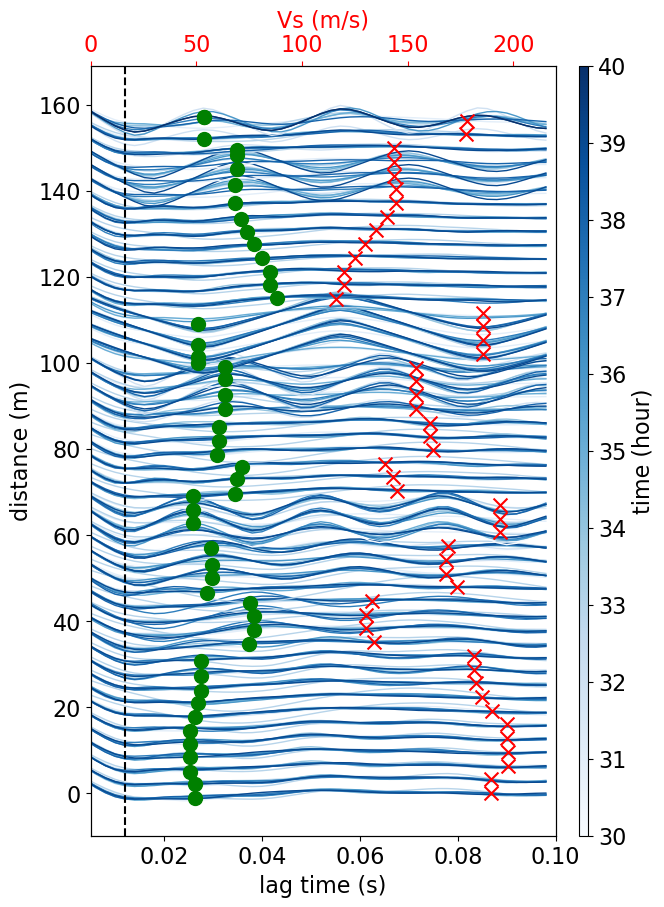

In [5]:
with h5py.File(os.path.join(data_dir, 'autocorr_15_60Hz_30_40min.hdf5'), 'r') as f:
    corr_all_time = f['corr_all_channel_30_40min'][:]
    
plt.figure(figsize = (6, 10))
plt.xlim(0.005, 0.1)
plt.ylabel('distance (m)', fontsize=16)
for iloc in np.arange(0,50,1):
    data_plot=corr_all_time[iloc, :, :50].T
    x=np.arange(data_plot.shape[1])
    y=np.arange(data_plot.shape[0])

    
    for i in x[::1]:
        plt.plot(y/samp_freq, data_plot[:,i]*6+iloc*3.19, color=plt.cm.Blues((i-x[0]) / len(x)), lw=1)

    # plt.plot(y/samp_freq, np.mean(data_plot+iloc, axis=1), c='k', lw=9, alpha=0.3)

    plt.xlabel('lag time (s)')
    plt.scatter(1/f0[iloc], data_plot[int(samp_freq/f0[iloc]),0]*6+iloc*3.19, color='green', s=100, zorder=10)
plt.plot(y/samp_freq, data_plot[:,i]*6+iloc*3.19, color=plt.cm.Blues(i-x[0] / len(x)), lw=1, label='raw ACF')
plt.scatter(1/f0[iloc], data_plot[int(samp_freq/f0[iloc]),0]*6+iloc*3.19, color='green', s=100, zorder=10, label='$f_0$')
# plt.legend(loc='lower right')

plt.axvline(x=win_st/samp_freq, color='k', linestyle='--')
# plt.title('raw ACF')
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), label='time (hour)', cax=plt.gca().inset_axes([1.05, 0, 0.02, 1]))
cbar.set_ticks(np.linspace(0, 1, num=11))
cbar.set_ticklabels(np.linspace(30, 40, num=11).astype(int))


twiny = plt.gca().twiny()
for iloc in np.arange(0,50,1):
    data_plot=corr_all_time[iloc, :, :50].T
    vs = H * f0[iloc]
    twiny.scatter(vs, iloc*3.19, color='red', s=100, zorder=10, marker='x')
twiny.set_xlabel('Vs (m/s)', color='red')
twiny.tick_params(axis='x', colors='red')
twiny.set_xlim(0, 220)
plt.show()


## dV/V

In [6]:
with h5py.File(os.path.join(data_dir, 'final_peaks_deRatio_3iterations.h5'), 'r') as f:
    deratio_dvv = f['deratio_dvv'][:]
deratio_dvv.shape

(50, 482)

## Stretched ACFs

In [7]:
with h5py.File(os.path.join(data_dir, 'autocorr_15_60Hz_3chs500pts.hdf5'), 'r') as f:
    corr_all_time_stretched1_ch18 = f['corr_all_time_stretched1_ch18'][:]
    corr_all_time_stretched1_ch33 = f['corr_all_time_stretched1_ch33'][:]
    corr_all_time_stretched1_ch44 = f['corr_all_time_stretched1_ch44'][:]
    corr_all_time_stretched2_ch18 = f['corr_all_time_stretched2_ch18'][:]
    corr_all_time_stretched2_ch33 = f['corr_all_time_stretched2_ch33'][:]
    corr_all_time_stretched2_ch44 = f['corr_all_time_stretched2_ch44'][:] 
    corr_all_time_stretched3_ch18 = f['corr_all_time_stretched3_ch18'][:]
    corr_all_time_stretched3_ch33 = f['corr_all_time_stretched3_ch33'][:]
    corr_all_time_stretched3_ch44 = f['corr_all_time_stretched3_ch44'][:] 

(0.0, 1.0)

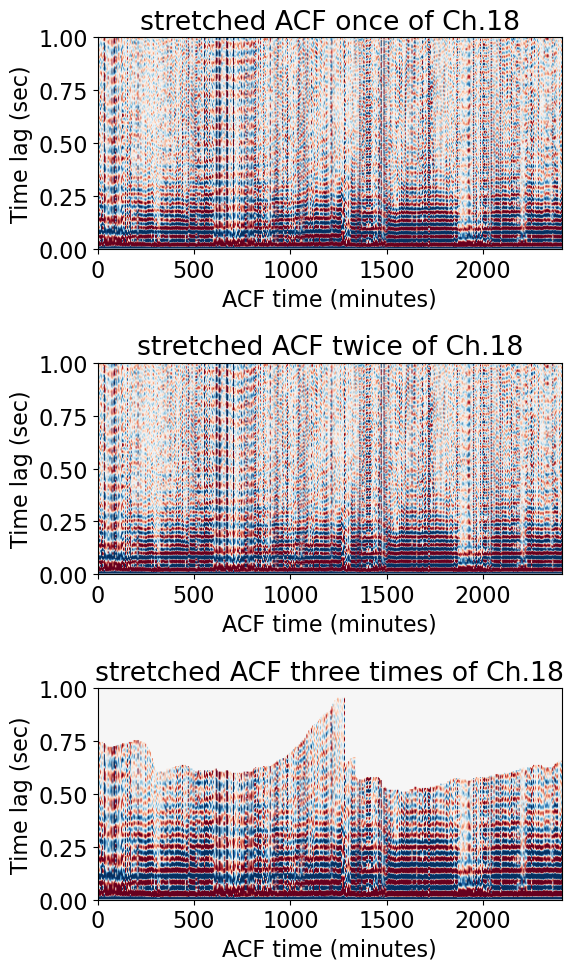

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10), tight_layout=True)

ax1.imshow(corr_all_time_stretched1_ch18.T, aspect='auto', vmin=-0.1, vmax=0.1, cmap='RdBu', origin='lower', extent=[0, 482*5, 0, 500/samp_freq])
ax1.set_xlabel("ACF time (minutes)", fontsize = 16)
ax1.set_ylabel("Time lag (sec)", fontsize = 16)
ax1.set_title('stretched ACF once of Ch.18')

ax2.imshow(corr_all_time_stretched2_ch18.T, aspect='auto', vmin=-0.1, vmax=0.1, cmap='RdBu', origin='lower', extent=[0, 482*5, 0, 500/samp_freq])
ax2.set_xlabel("ACF time (minutes)", fontsize = 16)
ax2.set_ylabel("Time lag (sec)", fontsize = 16)
ax2.set_title('stretched ACF twice of Ch.18')

ax3.imshow(corr_all_time_stretched3_ch18.T, aspect='auto', vmin=-0.1, vmax=0.1, cmap='RdBu', origin='lower', extent=[0, 482*5, 0, 500/samp_freq])
ax3.set_xlabel("ACF time (minutes)", fontsize = 16)
ax3.set_ylabel("Time lag (sec)", fontsize = 16)
ax3.set_title('stretched ACF three times of Ch.18')

ax3.set_ylim(0, 1)

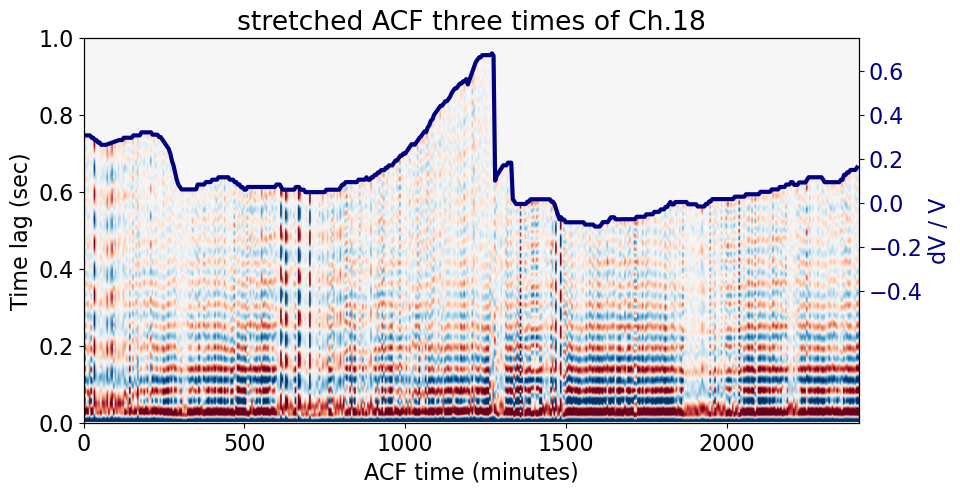

In [11]:
plt.figure(figsize=(10, 5))

plt.imshow(corr_all_time_stretched3_ch18.T, aspect='auto', vmin=-0.3, vmax=0.3, cmap='RdBu', origin='lower', extent=[0, 482*5, 0, 500/samp_freq], interpolation=None)
plt.xlabel("ACF time (minutes)", fontsize = 16)
plt.ylabel("Time lag (sec)", fontsize = 16)
plt.title('stretched ACF three times of Ch.18')
twinx = plt.gca().twinx()
twinx.plot(np.arange(482)*5, deratio_dvv[18], color='navy', lw=3)
twinx.set_ylim(-1, 0.75)
twinx.set_yticks(np.arange(-0.4, 0.7, 0.2))
twinx.tick_params(axis='y', colors='navy')
twinx.set_ylabel('dV / V', color='navy')
plt.savefig(os.path.join('./stretched_acf_3times_ch18'+'.pdf'), dpi=300)

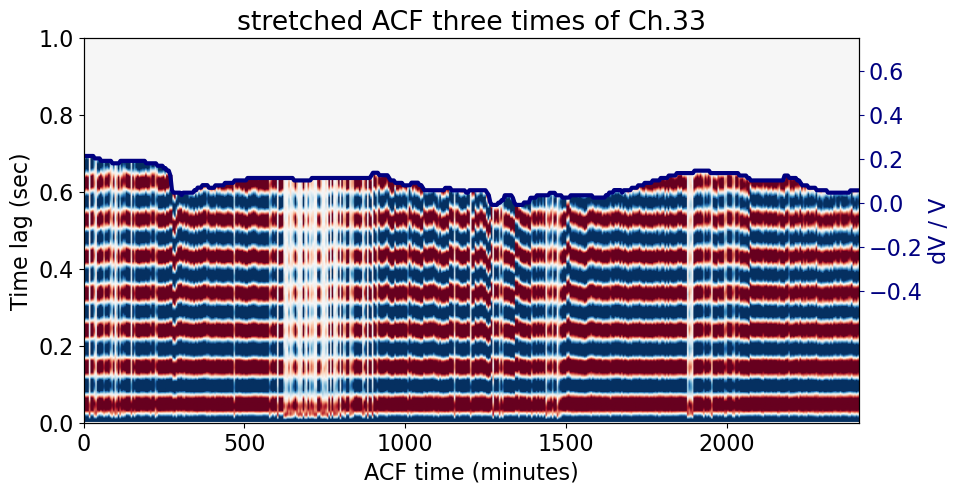

In [13]:
plt.figure(figsize=(10, 5))

plt.imshow(corr_all_time_stretched3_ch33.T, aspect='auto', vmin=-0.3, vmax=0.3, cmap='RdBu', origin='lower', extent=[0, 482*5, 0, 500/samp_freq], interpolation=None)
plt.xlabel("ACF time (minutes)", fontsize = 16)
plt.ylabel("Time lag (sec)", fontsize = 16)
plt.title('stretched ACF three times of Ch.33')
twinx = plt.gca().twinx()
twinx.plot(np.arange(482)*5, deratio_dvv[33], color='navy', lw=3)
twinx.set_ylim(-1, 0.75)
twinx.set_yticks(np.arange(-0.4, 0.7, 0.2))
twinx.tick_params(axis='y', colors='navy')
twinx.set_ylabel('dV / V', color='navy')
plt.savefig(os.path.join('./stretched_acf_3times_ch33'+'.pdf'), dpi=300)

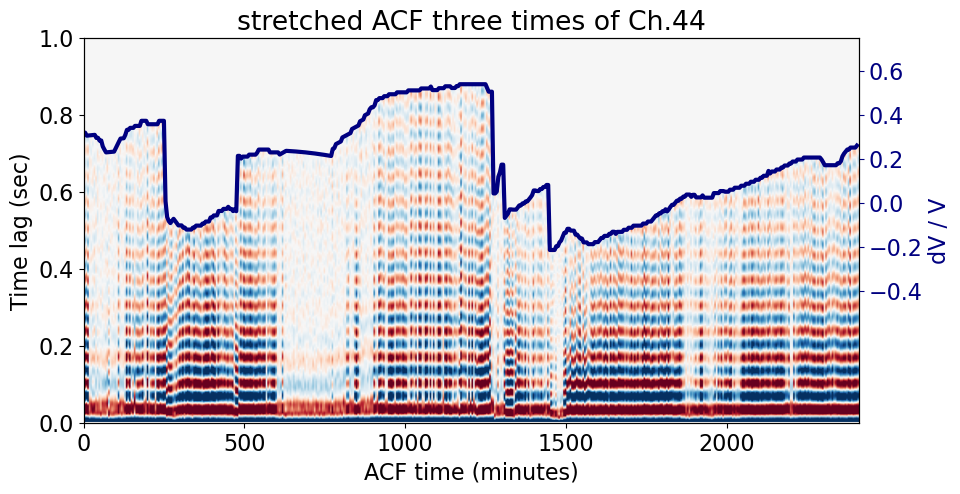

In [14]:
plt.figure(figsize=(10, 5))

plt.imshow(corr_all_time_stretched3_ch44.T, aspect='auto', vmin=-0.3, vmax=0.3, cmap='RdBu', origin='lower', extent=[0, 482*5, 0, 500/samp_freq], interpolation=None)
plt.xlabel("ACF time (minutes)", fontsize = 16)
plt.ylabel("Time lag (sec)", fontsize = 16)
plt.title('stretched ACF three times of Ch.44')
twinx = plt.gca().twinx()
twinx.plot(np.arange(482)*5, deratio_dvv[44], color='navy', lw=3)
twinx.set_ylim(-1, 0.75)
twinx.set_yticks(np.arange(-0.4, 0.7, 0.2))
twinx.tick_params(axis='y', colors='navy')
twinx.set_ylabel('dV / V', color='navy')
plt.savefig(os.path.join('./stretched_acf_3times_ch44'+'.pdf'), dpi=300)